In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mpmath as mp
import scipy.special as sc
from functools import partial
from scipy.integrate import quad
import sympy as smp

In [3]:
def τ(w_i, w_j, x, y):
    """j invades i, starting at freq y and reaching freq x
    """
    return np.log((x * (1-y)) / ((1-x) * y)) / np.log(w_j / w_i)


def T(N, μ1, μ2, δ, w_euwt, w_anwt, w_anmt, w_eumt, x_0=0, PLOT_N=False, PLOT_δ=False ):
    assert w_euwt < w_anwt < w_anmt < w_eumt
    p_euwt_eumt = 1 - (1 - 2*((w_eumt - w_euwt) / w_euwt) * μ1)**N
    p_euwt_anwt = 1 - (1 - 2*((w_anwt - w_euwt) / w_euwt) * δ)**N
    p_anwt_anmt = 1 - (1 - 2*((w_anmt - w_anwt) / w_anwt) * μ2)**N
    # no fix of anmt - use w_anwt; 
    δ=np.array([δ])
    if δ.all() == 0:
        p_anmt_eumt = 1
    else: p_anmt_eumt = 1 - (1 - 2*((w_eumt - w_anwt) / w_anwt) * δ)**N # N doesnt make sense here...
    

    
    p_min = 1 - (1 - p_euwt_eumt) * (1 - p_euwt_anwt)
    p_a = p_euwt_anwt / (p_euwt_eumt + p_euwt_anwt)
    
    # 
    τ_euwt_eumt = τ(w_euwt, w_eumt, x=0.95, y=np.maximum(x_0,1/N))
    # start with one or delta*N individuals  # why delta*N and not 2*s*delta*N
    τ_euwt_anwt = τ(w_euwt, w_anwt, x=1-1/N, y=np.maximum(δ, 1/N)) 
    # 
    τ_anwt_anmt = τ(w_anwt, w_anmt, x=1-1/N, y=np.maximum(μ2,1/N))
     # no fix of anmt - use w_anwt; # start with one or delta*N individuals
    τ_anmt_eumt = τ(w_anwt, w_eumt, x=0.95, y=np.maximum(δ, 1/N))
    
    T_m = 1/p_min + τ_euwt_eumt
    T_a = (
        1/p_min 
        + 1/p_anwt_anmt 
        + 1/p_anmt_eumt 
        + τ_euwt_anwt  
#        + τ_anwt_anmt  # no fix of anmt, don't count
        + τ_anmt_eumt 
    )             
    T =  p_a * T_a + (1 - p_a) * T_m
    
    if PLOT_N:
        plt.plot(N, 1/p_min, label='T_min', color='blue')
        plt.plot(N, 1/p_anwt_anmt, label='T_anwt_anmt', color='orange' )
        plt.plot(N, 1/p_anmt_eumt, label='T_anmt_eumt', color='red' )
        plt.plot(N, τ_euwt_anwt, '--', label='τ_euwt_anwt', color='orange')
        plt.plot(N, τ_anwt_anmt, '--', label='τ_anwt_anmt', color='red')
        plt.plot(N, τ_anmt_eumt, '--', label='τ_anmt_eumt', color='purple')
        plt.legend()
#         plt.yscale('log')
        plt.xscale('log')
        plt.ylim(0, None)
        
    if PLOT_δ:
        plt.plot(δ, 1/p_min, label='T_min', color='blue')
        plt.plot(δ, [1/p_anwt_anmt for d in δ], label='T_anwt_anmt', color='orange' )
        plt.plot(δ, 1/p_anmt_eumt, label='T_anmt_eumt', color='red' )
        plt.plot(δ, τ_euwt_anwt, '--', label='τ_euwt_anwt', color='orange')
        plt.plot(δ, [τ_anwt_anmt for d in δ], '--', label='τ_anwt_anmt', color='red')
        plt.plot(δ, τ_anmt_eumt, '--', label='τ_anmt_eumt', color='purple')
        plt.legend()
#         plt.yscale('log')
        plt.xscale('log')
        plt.ylim(0, None)
    return T

In [4]:
def integral(f, N, s, a, b):
    f = partial(f, N, s)    
    return quad(f, a, b)[0] #  limit=100

def mpintegral(f, N, s, a, b):
    f = partial(f, N, s)    
    return mp.quad(f, [a, b], verbose=False)

def I1(N, s, x):
    if x == 1:
        return 0
    S = 2*N*s
#     return np.expm1(S*x) * (np.exp(-S*x) - np.exp(-S)) / (x * (1-x)) # first term overflow so I rearranged:
    return (np.exp(-S) - np.exp(-S*x) - np.expm1(-S*(1-x))) / (x * (1-x))

def I2(N, s, x):
    if x == 0:
        return 0
    S = 2*N*s
    # use mp instad of np for high precision due to expm1(S*x)
    return -mp.expm1(S*x) * mp.expm1(-S*x) / (x * (1-x)) 

def p_kimura(N, s, x0=None):
    if x0 is None: x0 = 1 / N
    S = 2 * N * s
    numer = np.expm1(-S * x0)
    denom = np.expm1(-S)
    return numer / denom

@np.vectorize
def τ_kimura(N, w_i, w_j, x, y):
    """j invades i, starting at freq y and reaching freq x
    """
    s = (w_j - w_i) / w_i    
    x0, max_x, min_x = y, x, 0
    S = 2 * N * s
    J1 = -1.0 / (s * np.expm1(-S)) * integral(I1, N, s, x0, max_x)
    u = p_kimura(N, s, x0)
    # use mpintegral with mp.quad for high precision due to expm1(S*x) in I2
    J2 = -1.0 / (s * np.expm1(-S)) * mpintegral(I2, N, s, min_x, x0)
#     print(J1, J2, u, 1-u)
    return J1 + ((1 - u) / u) * J2 # eq 17 in Kimura & Ohta, Genetics 1969


In [5]:
def T_kimura(N, μ1, μ2, δ, w_euwt, w_anwt, w_anmt, w_eumt, x_0=0):
    assert w_euwt < w_anwt < w_anmt < w_eumt
    p_euwt_eumt = 1 - (1 - p_kimura(N, (w_eumt - w_euwt) / w_euwt) * μ1)**N
    p_euwt_anwt = 1 - (1 - p_kimura(N, (w_anwt - w_euwt) / w_euwt) * δ)**N
    p_anwt_anmt = 1 - (1 - p_kimura(N, (w_anmt - w_anwt) / w_anwt) * μ2)**N
    # no fix of anmt - use w_anwt; 
#     p_anmt_eumt = 1 - (1 - p_kimura(N, (w_eumt - w_anwt) / w_anwt) * δ)**N # N doesnt make sense here but it doesnt seem to matter
    
    δ=np.array([δ])
    if δ.all() == 0:
        p_anmt_eumt = 1
    else: p_anmt_eumt = 1 - (1 - p_kimura(N, (w_eumt - w_anwt) / w_anwt) * δ)**N  # N doesnt make sense here...
    

    p_min = 1 - (1 - p_euwt_eumt) * (1 - p_euwt_anwt)
    p_a = p_euwt_anwt / (p_euwt_eumt + p_euwt_anwt)
    
    # τ_kimura(N, s, x0=None, max_x=1, min_x=0)
    τ_euwt_eumt = τ_kimura(N, w_euwt, w_eumt, x=0.95, y=np.maximum(x_0,1/N))
    # start with one or delta*N individuals
    τ_euwt_anwt = τ_kimura(N, w_euwt, w_anwt, x=1-1/N, y=np.maximum(δ, 1/N)) 
    # no fix of anmt, don't count
    # τ_anwt_anmt = τ_kimura(N, w_anwt, w_anmt, x=1-1/N, y=1/N)
    # no fix of anmt - use w_anwt; # start with one or delta*N individuals
    τ_anmt_eumt = τ_kimura(N, w_anwt, w_eumt, x=0.95, y=np.maximum(δ, 1/N))
    
    T_m = 1/p_min + τ_euwt_eumt
    T_a = (
        # euwt->anwt
        1/p_min 
        + τ_euwt_anwt 
        # anwt->anmt
        + 1/p_anwt_anmt 
#         + τ_anwt_anmt  # no fix of anmt, don't count
        # anmt->eumt
        + 1/p_anmt_eumt
        + τ_anmt_eumt 
    )             
    T =  p_a * T_a + (1 - p_a) * T_m
    return T

In [98]:
def t_gen1(α, β, p, x):
    if 0 <= β < 1/2:
        pf = (mp.gammainc(1-2*β)-mp.gammainc(1-2*β, 2*x*α))/(mp.gammainc(1-2*β)-mp.gammainc(1-2*β, 2*p*α))
    else:
        pf=1
    return pf*(2/(1-x)) * mp.exp(2*x*α) * x**(2*β-1) * (p**(1-2*β)*smp.expint(2*β, 2*p*α) - smp.expint(2*β, 2*α))

def t_gen2(α, β, p, x):
    return (2/(1-x)) * mp.exp(2*x*α) * (smp.expint(2*β, 2*x*α) - x**(2*β-1)*smp.expint(2*β, 2*α))

@np.vectorize
def τ_rec_ft(N, rate, w_i, w_j, p, fc=1):
    """j invades i, starting at freq p and reaching fc"""
    s = (w_j - w_i) / w_i   
    α=2*N*s
    β=2*N*rate
    t1=partial(t_gen1, α, β, p)
    t2=partial(t_gen2, α, β, p)
    return N*(mp.quad(t1,[0,p])+mp.quad(t2,[p,fc]))*2

def t_gen1_mp(α, β, p, x):
    return (2/(1-x)) * mp.exp(2*x*α) * x**(2*β-1) * (p**(1-2*β)*mp.expint(2*β, 2*p*α) - mp.expint(2*β, 2*α))

def t_gen2_mp(α, β, p, x):
    return (2/(1-x)) * mp.exp(2*x*α) * (mp.expint(2*β, 2*x*α) - x**(2*β-1)*mp.expint(2*β, 2*α))

@np.vectorize
def τ_rec_ft_mp(N, rate, w_i, w_j, p, fc=1):
    """j invades i, starting at freq p and reaching fc"""
    s = (w_j - w_i) / w_i   
    α=2*N*s
    β=2*N*rate
    t1=partial(t_gen1_mp, α, β, p)
    t2=partial(t_gen2_mp, α, β, p)
    return 2*N*(mp.quad(t1,[0,p])+mp.quad(t2,[p,fc]))


@np.vectorize
def τ_rec_ft_lambda(N, rate, w_i, w_j, p, fc=1):
    """j invades i, starting at freq p and reaching 1"""
    s = (w_j - w_i) / w_i   
    α=2*N*s
    β=2*N*rate
    t1=lambda x: (2*N/(1-x)) * mp.exp(2*x*α) * x**(2*β-1) * (p**(1-2*β)*smp.expint(2*β, 2*p*α) - smp.expint(2*β, 2*α))
    t2=lambda x: (2*N/(1-x)) * mp.exp(2*x*α) * (smp.expint(2*β, 2*x*α) - x**(2*β-1)*smp.expint(2*β, 2*α))
    return mp.quad(t1,[0,p])+mp.quad(t2,[p,fc]) #follows Ewens book

In [28]:
def t_g1(α, β, p, x):
    t = (2/(1-x)) * mp.exp(2*x*α) * x**(2*β-1) * (p**(1-2*β)*mp.expint(2*β, 2*p*α) - mp.expint(2*β, 2*α))
    return np.float64(t)

def t_g2(α, β, p, x):
    t = (2/(1-x)) * mp.exp(2*x*α) * (mp.expint(2*β, 2*x*α) - x**(2*β-1)*mp.expint(2*β, 2*α))
    return np.float64(t)

@np.vectorize
def τ_recmut(N, rate, w_i, w_j, p, fc=1):
    """j invades i, starting at freq p and reaching fc"""
    s = (w_j - w_i) / w_i   
    α = 2*N*s
    β = 2*N*rate
    t1 = partial(t_g1, α, β, p)
    t2 = partial(t_g2, α, β, p)
    return 2*N*(quad(t1,0,p)[0]+quad(t2,p,fc)[0])

In [8]:
def T_rec(N, μ1, μ2, δ, w_euwt, w_anwt, w_anmt, w_eumt, x_0=0, fc=.95):
    assert w_euwt < w_anwt < w_anmt < w_eumt
    p_euwt_eumt = 1 - (1 - p_kimura(N, (w_eumt - w_euwt) / w_euwt) * μ1)**N
    p_euwt_anwt = 1 - (1 - p_kimura(N, (w_anwt - w_euwt) / w_euwt) * δ)**N
    p_anwt_anmt = 1 - (1 - p_kimura(N, (w_anmt - w_anwt) / w_anwt) * μ2)**N
    # no fix of anmt - use w_anwt; 
#     p_anmt_eumt = 1 - (1 - p_kimura(N, (w_eumt - w_anwt) / w_anwt) * δ)**N # N doesnt make sense here but it doesnt seem to matter
    
    δ=np.array([δ])
    if δ.all() == 0:
        p_anmt_eumt = 1
    else: p_anmt_eumt = 1 - (1 - p_kimura(N, (w_eumt - w_anwt) / w_anwt) * δ)**N  # N doesnt make sense here...
    

    p_min = 1 - (1 - p_euwt_eumt) * (1 - p_euwt_anwt)
    p_a = p_euwt_anwt / (p_euwt_eumt + p_euwt_anwt)
    
    # τ_kimura(N, s, x0=None, max_x=1, min_x=0)
    τ_euwt_eumt = τ_rec_ft(N, μ1, w_euwt, w_eumt, p=np.maximum(x_0,1/N),fc=fc)
    # start with one or delta*N individuals
    τ_euwt_anwt = τ_rec_ft(N, δ, w_euwt, w_anwt, p=np.maximum(δ, 1/N),fc=fc) 
    # no fix of anmt, don't count
    # τ_anwt_anmt = τ_kimura(N, w_anwt, w_anmt, x=1-1/N, y=1/N)
    # no fix of anmt - use w_anwt; # start with one or delta*N individuals
    τ_anmt_eumt = τ_rec_ft(N, δ, w_anwt, w_eumt, p=np.maximum(δ, 1/N),fc=fc)
    
    T_m = 1/p_min + τ_euwt_eumt
    T_a = (
        # euwt->anwt
        1/p_min 
        + τ_euwt_anwt 
        # anwt->anmt
        + 1/p_anwt_anmt 
#         + τ_anwt_anmt  # no fix of anmt, don't count
        # anmt->eumt
        + 1/p_anmt_eumt
        + τ_anmt_eumt 
    )             
    T =  p_a * T_a + (1 - p_a) * T_m
    return T

# Comparison:

## Population size

In [9]:
Nm58, msim_noaneuN_manu58=np.load('msim_noaneuN_manu58.npy',allow_pickle=True)
Nm58 = Nm58.astype('float64')

msim_noaneuN58=np.array([x for x in msim_noaneuN_manu58[0]])

In [75]:
N, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt = Nm58, 9.6e-08, 0, 1, 1.021, 1.025, 1.028

In [12]:
%timeit τ_rec_ft_lambda(N, μ , w_euwt, w_eumt, 1/N, fc=0.95)
%timeit τ_rec_ft(N, μ , w_euwt, w_eumt, 1/N, fc=0.95)

12.4 s ± 21.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10 s ± 25.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [113]:
%timeit τ_rec_ft_lambda(N, μ , w_euwt, w_eumt, 1/N, fc=0.95)
%timeit τ_rec_ft(N, μ , w_euwt, w_eumt, 1/N, fc=0.95)
%timeit τ_rec_ft_mp(N, μ , w_euwt, w_eumt, 1/N, fc=0.95)

10.1 s ± 249 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.61 s ± 101 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10.1 s ± 62.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit τ_rec_ft(N, μ , w_euwt, w_eumt, 1/N, fc=0.95)

7.54 s ± 88.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%timeit τ_recmut(N,  μ , w_euwt, w_eumt, 1/N, fc=0.95)

17.7 s ± 84.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [114]:
τ__= τ(w_euwt, w_eumt, .95, 1/N)
τ_K= τ_kimura(N, w_euwt, w_eumt, x=.95, y=1/N)
τ_r= τ_rec_ft(N, μ , w_euwt, w_eumt, 1/N, fc=0.95)

In [17]:
p0 = 1 - (1 - p_kimura(N, (w_eumt - w_euwt) / w_euwt) * μ)**N
p1 = 1 - (1 - p_kimura(N, (w_anwt - w_euwt) / w_euwt) * δ)**N
p_mint = 1 - (1 - p0) * (1 - p1)
p_at= p1 / (p0 + p1)

In [43]:
p0h = 1 - (1 - 2*(w_eumt - w_euwt)* μ / w_euwt )**N
p1h = 1 - (1 - 2*(w_anwt - w_euwt)* δ / w_euwt) **N
p_minth = 1 - (1 - p0h) * (1 - p1h)
p_ath= p1h / (p0h + p1h)

In [56]:
(1/p_mint- 1/p_minth)/(1/p_mint)

(array([0.02747738, 0.02747629, 0.02747504, 0.0274736 , 0.02747194,
        0.02747003, 0.02746783, 0.0274653 , 0.02746238, 0.02745902,
        0.02745516, 0.0274507 , 0.02744558, 0.02743968, 0.02743289,
        0.02742507, 0.02741607, 0.02740571, 0.02739379, 0.02738006,
        0.02736426, 0.02734608, 0.02732515, 0.02730107, 0.02727336,
        0.02724147, 0.02720479, 0.02716259, 0.02711406, 0.02705826,
        0.02699409, 0.02692034, 0.02683558, 0.02673821, 0.02662638,
        0.026498  , 0.02635069, 0.02618174, 0.02598811, 0.02576634,
        0.02551255, 0.0252224 , 0.02489108, 0.02451322, 0.02408298,
        0.02359399, 0.02303942, 0.0224121 , 0.02170461, 0.0209096 ]),
 array([1913.188507  , 1661.69952508, 1443.26541627, 1253.56343967,
        1088.79457471,  945.70040811,  821.41405393,  713.4742076 ,
         619.72562487,  538.3039563 ,  467.58943396,  406.17258242,
         352.83118746,  306.50349819,  266.26776229,  231.32241246,
         200.97190578,  174.61218346,  151.718

In [52]:
p0g = 1 - (1 -  μ )**N
p1g = 1 - (1 -  δ ) **N
p_mintg = 1 - (1 - p0g) * (1 - p1g)
p_atg= p1g / (p0g + p1g)

In [62]:
1/p_mint-1/p_mintg

array([1.80852105e+03, 1.57072825e+03, 1.36419011e+03, 1.18481931e+03,
       1.02902371e+03, 8.93722365e+02, 7.76204509e+02, 6.74142878e+02,
       5.85499600e+02, 5.08511853e+02, 4.41648075e+02, 3.83575543e+02,
       3.33138598e+02, 2.89333299e+02, 2.51288081e+02, 2.18245016e+02,
       1.89546424e+02, 1.64621123e+02, 1.42972974e+02, 1.24170969e+02,
       1.07840810e+02, 9.36573686e+01, 8.13383513e+01, 7.06385454e+01,
       6.13449091e+01, 5.32724652e+01, 4.62605130e+01, 4.01694658e+01,
       3.48780845e+01, 3.02810387e+01, 2.62868349e+01, 2.28159781e+01,
       1.97994102e+01, 1.71771240e+01, 1.48969926e+01, 1.29137296e+01,
       1.11880054e+01, 9.68568731e+00, 8.37717696e+00, 7.23685239e+00,
       6.24258344e+00, 5.37531115e+00, 4.61867209e+00, 3.95864729e+00,
       3.38322332e+00, 2.88206184e+00, 2.44618987e+00, 2.06773554e+00,
       1.73973183e+00, 1.45599222e+00])

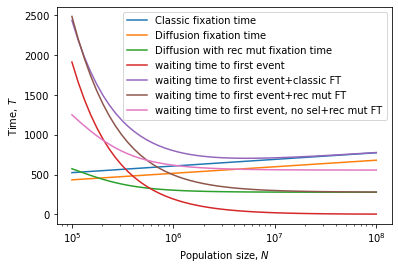

In [68]:
plt.plot(N, τ__, label='Classic fixation time')
plt.plot(N, τ_K, label='Diffusion fixation time')
plt.plot(N, τ_r, label='Diffusion with rec mut fixation time')
plt.plot(N, 1/p_mint, label='waiting time to first event')
plt.plot(N, 1/p_mint+τ__, label='waiting time to first event+classic FT')
plt.plot(N, 1/p_mint+τ_r, label='waiting time to first event+rec mut FT')
plt.plot(N, 1/p_mintg+2*τ_r, label='waiting time to first event, no sel+rec mut FT')

plt.xscale('log')
#plt.yscale('log')
#plt.xlim([1e7,1e8])
#plt.ylim([500,700])
plt.xlabel("Population size, $N$")
plt.ylabel('Time, $T$')
plt.legend();

In [16]:
p0,p1,1/p_mint,p_at

(array([0.00052269, 0.00060179, 0.00069287, 0.00079773, 0.00091845,
        0.00105742, 0.00121741, 0.00140159, 0.00161362, 0.00185769,
        0.00213863, 0.00246201, 0.00283422, 0.00326261, 0.00375562,
        0.00432297, 0.00497582, 0.00572698, 0.00659115, 0.00758523,
        0.00872857, 0.01004338, 0.01155508, 0.01329279, 0.0152898 ,
        0.01758415, 0.02021922, 0.02324448, 0.02671618, 0.03069821,
        0.03526292, 0.04049208, 0.04647782, 0.05332355, 0.06114483,
        0.07007021, 0.08024183, 0.09181565, 0.10496142, 0.11986191,
        0.13671128, 0.15571245, 0.1770729 , 0.20099873, 0.22768654,
        0.25731258, 0.29001904, 0.32589719, 0.36496734, 0.40715619]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1913.188507  , 1661.69952508, 1443.26541627, 1253.56343967,
        1088.79457471,  

In [99]:
T__=T(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt)#, x_0=35*μ)
T_K=T_kimura(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt)#, x_0=35*μ)
T_r=T_rec(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt, fc=.95)#, x_0=35*μ)

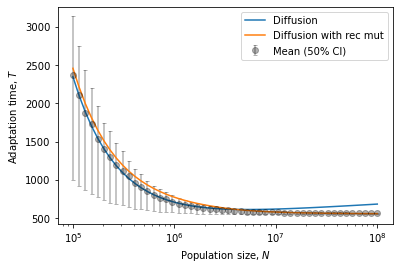

In [103]:
mean = msim_noaneuN58.mean(axis=1)
low = np.percentile(msim_noaneuN58, 25, axis=1)
high = np.percentile(msim_noaneuN58, 75, axis=1)
plt.errorbar(N, mean, [(mean-low), (high-mean)],fmt='o', color='k', capsize=2, label='Mean (50% CI)', alpha=.3)

#plt.plot(N, T__, label='Classic')
plt.plot(N, T_K, label='Diffusion')
plt.plot(N, T_r, label='Diffusion with rec mut')
#plt.plot(N, T_rr, label='Diffusion with rec mut')
#plt.plot(N, 1/p_mint+2*τ_r, label='waiting time to first event, no sel+rec mut FT')
#plt.plot(N, 1/p_mint+τ__, label='waiting time to first event+rec mut FT')

plt.xscale('log')
#plt.yscale('log')
#plt.xlim([1e7,1e8])
#plt.ylim([525,600])
plt.xlabel("Population size, $N$")
plt.ylabel('Adaptation time, $T$')
plt.legend()
plt.savefig('Diffusion with mutation_N.pdf');

In [80]:
sum(2*N*μ<1/2)

24

In [86]:
N[23]

2559547.0

In [85]:
(2*N*μ)[23]

0.491433024

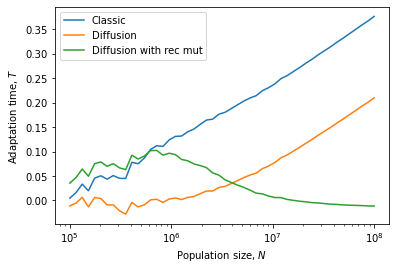

In [42]:
plt.plot(N, (T__-mean)/mean, label='Classic')
plt.plot(N, (T_K-mean)/mean, label='Diffusion')
plt.plot(N, (T_r-mean)/mean, label='Diffusion with rec mut')
#plt.plot(N, T_rr, label='Diffusion with rec mut')
#plt.plot(N, 1/p_mint+2*τ_r, label='waiting time to first event, no sel+rec mut FT')
#plt.plot(N, 1/p_mint+τ__, label='waiting time to first event+rec mut FT')

plt.xscale('log')
#plt.yscale('log')
#plt.xlim([1e7,1e8])
#plt.ylim([525,600])
plt.xlabel("Population size, $N$")
plt.ylabel('Adaptation time, $T$')
plt.legend();

## Mutation rate

In [55]:
μm, msim_noaneuμ_manu=np.load('msim_noaneuμ_manu.npy',allow_pickle=True)
μm = μm.astype('float64')

msim_noaneuμ_manu=np.array([x for x in msim_noaneuμ_manu[0]])

In [122]:
N, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt = 6e6, μm, 0, 1, 1.021,1.025, 1.028

In [57]:
τ__= [τ(w_euwt, w_eumt, .95, 1/N) for x in μ]
τ_K= [τ_kimura(N, w_euwt, w_eumt, x=.95, y=1/N) for x in μ]
τ_r= τ_rec_ft(N, μ , w_euwt, w_eumt, 1/N, fc=0.95)

In [79]:
p0 = 1 - (1 - p_kimura(N, (w_eumt - w_euwt) / w_euwt) * μ)**N
p1 = 1 - (1 - p_kimura(N, (w_anwt - w_euwt) / w_euwt) * δ)**N
p_mint = 1 - (1 - p0) * (1 - p1)
p_at= p1 / (p0 + p1)

In [80]:
p0g = 1 - (1 -  μ )**N
p1g = 1 - (1 -  δ ) **N
p_mintg = 1 - (1 - p0g) * (1 - p1g)
p_atg= p1g / (p0g + p1g)

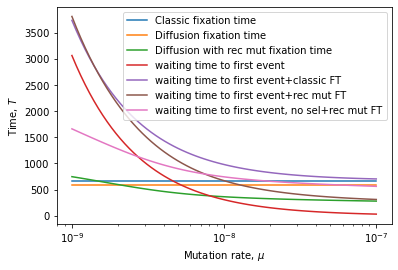

In [88]:
plt.plot(μ, τ__, label='Classic fixation time')
plt.plot(μ, τ_K, label='Diffusion fixation time')
plt.plot(μ, τ_r, label='Diffusion with rec mut fixation time')
plt.plot(μ, 1/p_mint, label='waiting time to first event')
plt.plot(μ, 1/p_mint+τ__, label='waiting time to first event+classic FT')
plt.plot(μ, 1/p_mint+τ_r, label='waiting time to first event+rec mut FT')
plt.plot(μ, 1/p_mintg+2*τ_r, label='waiting time to first event, no sel+rec mut FT')

plt.xscale('log')
#plt.yscale('log')
#plt.xlim([1e7,1e8])
#plt.ylim([500,700])
plt.xlabel("Mutation rate, $μ$")
plt.ylabel('Time, $T$')
plt.legend();

In [123]:
T__ = T(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt) #, x_0=35*μ)
T_ = T_kimura(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt) #, x_0=35*μ)
T_r = T_rec(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt, fc=.95) #, x_0=35*μ)

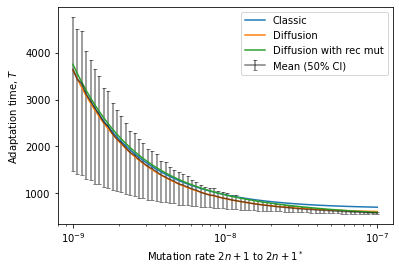

In [125]:
mean = np.mean(msim_noaneuμ_manu, axis=1)
low = np.percentile(msim_noaneuμ_manu, 25, axis=1)
high = np.percentile(msim_noaneuμ_manu, 75, axis=1)
plt.errorbar(μ, mean, [mean-low, high-mean], color='k', capsize=2, label='Mean (50% CI)', alpha=.5)

plt.plot(μ, T__, label='Classic')
plt.plot(μ, T_, label='Diffusion')
plt.plot(μ, T_r, label='Diffusion with rec mut')
#plt.plot(μ, 1/p_mint+2*τ_r, label='waiting time to first event, no sel+rec mut FT')

plt.xscale('log')
#plt.yscale('log')
#plt.xlim([1e-8,1e-7])
#plt.ylim([530,1000])
plt.xlabel("Mutation rate $2n+1$ to $2n+1^*$")
plt.ylabel('Adaptation time, $T$')
plt.legend()
plt.savefig('Diffusion with mutation_mu2.pdf');

In [105]:
μm68, msim_noaneuμ68_manu=np.load('msim_noaneuμ68_manu.npy',allow_pickle=True)
μm68= μm68.astype('float64')

msim_noaneuμ68_manu=np.array([x for x in msim_noaneuμ68_manu[0]])

In [106]:
N, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt = 6e6, μm68, 0, 1, 1.021,1.025, 1.028

In [72]:
2*N*μm68

array([ 0.12      ,  0.1282823 ,  0.13713625,  0.14660128,  0.15671959,
        0.16753625,  0.17909947,  0.19146077,  0.20467524,  0.21880176,
        0.23390328,  0.2500471 ,  0.26730515,  0.28575434,  0.30547688,
        0.32656065,  0.34909961,  0.37319419,  0.39895175,  0.42648708,
        0.45592288,  0.48739032,  0.52102961,  0.55699066,  0.59543371,
        0.63653007,  0.68046287,  0.72742788,  0.77763437,  0.83130608,
        0.88868216,  0.9500183 ,  1.01558781,  1.08568287,  1.16061584,
        1.24072062,  1.32635417,  1.41789808,  1.51576028,  1.62037685,
        1.73221397,  1.85177   ,  1.97957769,  2.11620657,  2.26226546,
        2.41840522,  2.58532163,  2.76375847,  2.95451088,  3.15842887,
        3.37642112,  3.60945902,  3.85858101,  4.1248972 ,  4.40959433,
        4.71394102,  5.03929348,  5.38710151,  5.75891497,  6.1563907 ,
        6.58129989,  7.03553598,  7.52112307,  8.040225  ,  8.59515494,
        9.1883857 ,  9.82256077, 10.5005061 , 11.22524268, 12.  

In [107]:
T__ = T(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt) #, x_0=35*μ)
T_ = T_kimura(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt) #, x_0=35*μ)
T_r = T_rec(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt, fc=.95) #, x_0=35*μ)

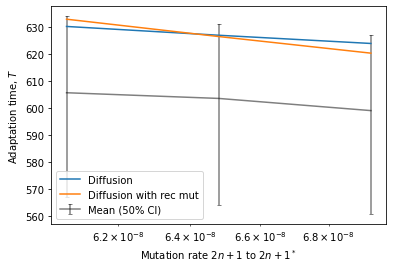

In [117]:
mean = np.mean(msim_noaneuμ68_manu, axis=1)
low = np.percentile(msim_noaneuμ68_manu, 25, axis=1)
high = np.percentile(msim_noaneuμ68_manu, 75, axis=1)
plt.errorbar(μ[27:30], mean[27:30], [(mean-low)[27:30], (high-mean)[27:30]], color='k', capsize=2, label='Mean (50% CI)', alpha=.5)

#plt.plot(μ, T__, label='Classic')
plt.plot(μ[27:30], T_[27:30], label='Diffusion')
plt.plot(μ[27:30], T_r[27:30], label='Diffusion with rec mut')

plt.xscale('log')
#plt.yscale('log')
#plt.xlim([1e-8,1e-7])
#plt.ylim([530,1000])
plt.xlabel("Mutation rate $2n+1$ to $2n+1^*$")
plt.ylabel('Adaptation time, $T$')
plt.legend()
plt.savefig('Diffusion with mutation_mu.pdf');

In [120]:
T_[27], T_r[27],  T_[28], T_r[28],  T_[29], T_r[29]

(mpf('630.21868830704329'),
 mpf('632.90492579694785'),
 mpf('626.95938527602971'),
 mpf('626.47738832203163'),
 mpf('623.91052822707888'),
 mpf('620.31986322506305'))

In [121]:
(2*N*μ)[28]

0.777634372849501